# Replay & Fork state

## State History using SDK

### Redefine financial advicer graph with intent checker (from 11_dynamic-breakpoints.ipynb)

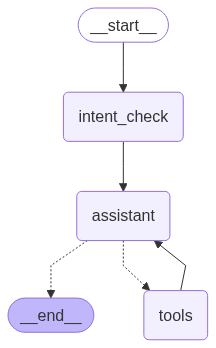

In [1]:
import requests
import yfinance as yf
from pprint import pformat
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.errors import NodeInterrupt


# Defining Tools
##################################################################################

def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "your_alphavantage_api_key_2"
    }
    
    response = requests.get(api_url, params=params)
    data = response.json()
    
    if "bestMatches" in data and data["bestMatches"]:
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."


def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        stock_info = stock.info  # Basic company and stock data
        stock_history = stock.history(period=period).to_dict()  # Historical OHLCV data

        # Combine both into a single dictionary
        combined_data = {
            "stock_symbol": stock_symbol,
            "info": stock_info,
            "history": stock_history
        }

        return pformat(combined_data)

    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


# Binding tools to the LLM
##################################################################################

# Create tool bindings with additional attributes
lookup_stock = Tool.from_function(
    func=lookup_stock_symbol,
    name="lookup_stock_symbol",
    description="Converts a company name to its stock symbol using a financial API.",
    return_direct=False  # Return result to be processed by LLM
)

fetch_stock = Tool.from_function(
    func=fetch_stock_data_raw,
    name="fetch_stock_data_raw",
    description="Fetches comprehensive stock data including general info and historical market data for a given stock symbol.",
    return_direct=False
)

toolbox = [lookup_stock, fetch_stock]

# OPENAI_API_KEY environment variable must be set
simple_llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = simple_llm.bind_tools(toolbox)


# Defining Agent's node
##################################################################################

# System message
assistant_system_message = SystemMessage(content=("""
You are a professional financial assistant specializing in stock market analysis and investment strategies. 
Your role is to analyze stock data and provide **clear, decisive recommendations** that users can act on, 
whether they already hold the stock or are considering investing.

You have access to a set of tools that can provide the data you need to analyze stocks effectively. 
Use these tools to gather relevant information such as stock symbols, current prices, historical trends, 
and key financial indicators. Your goal is to leverage these resources efficiently to generate accurate, 
actionable insights for the user.

Your responses should be:
- **Concise and direct**, summarizing only the most critical insights.
- **Actionable**, offering clear guidance on whether to buy, sell, hold, or wait for better opportunities.
- **Context-aware**, considering both current holders and potential investors.
- **Free of speculation**, relying solely on factual data and trends.
- **do not forget** to provide stock name in the report, so it's clear which stock is being recommended.

### Response Format:
1. **Recommendation:** Buy, Sell, Hold, or Wait.
2. **Key Insights:** Highlight critical trends and market factors that influence the decision.
3. **Suggested Next Steps:** What the user should do based on their current position.

If the user does not specify whether they own the stock, provide recommendations for both potential buyers and current holders. Ensure your advice considers valuation, trends, and market sentiment.

Your goal is to help users make informed financial decisions quickly and confidently.
"""))

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([assistant_system_message] + state["messages"])]}

def intent_check(state: MessagesState):
    user_request = state["messages"][-1].content

    financial_check_prompt = f"""
    You are an intent classifier. Your task is to determine if the user's request is specifically related to finance, investments, or financial advice.

    Evaluate the following user request:

    "{user_request}"

    If the request is about finance, investments, or financial advice, respond with "True".
    If it is unrelated to finance, respond with "False".

    Respond with only "True" or "False" and nothing else.
    """

    llm_response = llm_with_tools.invoke([HumanMessage(content=financial_check_prompt)]).content
    is_financial_question = llm_response.strip().lower() == 'true'

    if not is_financial_question:
        raise NodeInterrupt("Please ask a question related to financial advice.")

    return state


# Defining Graph
##################################################################################
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("intent_check", intent_check)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "intent_check")
builder.add_edge("intent_check", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Execute the graph and interrupt it

In [2]:
# start a new conversation
thread = {"configurable": {"thread_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="What is the weather outside?")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is the weather outside?


C:\Users\jenny\AppData\Local\Temp\ipykernel_35408\4134531656.py:155: LangGraphDeprecatedSinceV10: NodeInterrupt is deprecated. Please use `langgraph.types.interrupt` instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  raise NodeInterrupt("Please ask a question related to financial advice.")


### Return current checkpoint

In [3]:
state = graph.get_state(thread)
print(state.next)
print("\n\n")
print(state)

('intent_check',)



StateSnapshot(values={'messages': [HumanMessage(content='What is the weather outside?', additional_kwargs={}, response_metadata={}, id='713d58a6-7d3c-47fc-b00c-aca7472b784f')]}, next=('intent_check',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad62-4c5d-6b2b-8000-0862bd464ee0'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-16T19:21:00.702186+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad62-4c5d-6b2a-bfff-1cbc99ce78c1'}}, tasks=(PregelTask(id='fd5073e4-cb62-4224-1baa-fe60b154542f', name='intent_check', path=('__pregel_pull', 'intent_check'), error=None, interrupts=(Interrupt(value='Please ask a question related to financial advice.', id='placeholder-id'),), state=None, result=None),), interrupts=(Interrupt(value='Please ask a question related to financial advice.', id='placeholder-id'),))


### Get the most recent Chekpoint
![get-most-recent-checkpoint](images/get-most-recent-checkpoint.png)

### Let's finish the graph

In [4]:
# start a new conversation
thread = {"configurable": {"thread_id": "2"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="What is a stock symbol for Tesla?")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is a stock symbol for Tesla?
================================ Human Message =================================

What is a stock symbol for Tesla?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_L0OoAkAuZPmYI0PbN48jvFo1)
 Call ID: call_L0OoAkAuZPmYI0PbN48jvFo1
  Args:
    __arg1: Tesla
================================= Tool Message =================================
Name: lookup_stock_symbol

TSLA
================================== Ai Message ==================================

The stock symbol for Tesla is **TSLA**.


In [5]:
state = graph.get_state(thread)
print(state.next)
print("\n\n")
print(state)

()



StateSnapshot(values={'messages': [HumanMessage(content='What is a stock symbol for Tesla?', additional_kwargs={}, response_metadata={}, id='59367aae-5f5a-40f7-bc27-0d1305153f2c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_L0OoAkAuZPmYI0PbN48jvFo1', 'function': {'arguments': '{"__arg1":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 416, 'total_tokens': 433, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5Gpprnf4DwUeVj4WLcZzBJemQ4qA', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--041869dd-9560-4347-abd1-25a5c737a3a1-0', tool_calls=[{'name': 'lookup_stock

### Multiple Checkpoints
![multiple-checkpoints](images/multiple-checkpoints.png)


In [6]:
all_states = [s for s in graph.get_state_history(thread)]
len(all_states)

6

### Replay the Graph

Let's replay the graph from assistant.

In [7]:
to_replay = all_states[-3]
to_replay.values

{'messages': [HumanMessage(content='What is a stock symbol for Tesla?', additional_kwargs={}, response_metadata={}, id='59367aae-5f5a-40f7-bc27-0d1305153f2c')]}

Check next Node to run

In [8]:
to_replay.next

('assistant',)

Check config with `checkpoint_id` and `thread_id`

In [9]:
to_replay.config

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f07ad6e-87dc-6c3d-8001-c45d1d04a38e'}}

and finally let's reply!

In [10]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is a stock symbol for Tesla?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_3jvm2kOVlqRFUQ6bEzZ31OHx)
 Call ID: call_3jvm2kOVlqRFUQ6bEzZ31OHx
  Args:
    __arg1: Tesla
================================= Tool Message =================================
Name: lookup_stock_symbol

TSLA
================================== Ai Message ==================================

The stock symbol for Tesla is **TSLA**.


**Important!**

Replay does not actually trigger real execution!

### Forking with SDK
![forking](images/forking.png)

In [11]:
to_fork = all_states[-3]
to_fork.values

{'messages': [HumanMessage(content='What is a stock symbol for Tesla?', additional_kwargs={}, response_metadata={}, id='59367aae-5f5a-40f7-bc27-0d1305153f2c')]}

In [12]:
print(to_fork.next)
print(to_fork.config)

('assistant',)
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad6e-87dc-6c3d-8001-c45d1d04a38e'}}


### Modify specific checkpoint

In [13]:
fork_config = graph.update_state(to_fork.config, {
    "messages": [HumanMessage(content='What is a stock symbol for nvidia?', id=to_fork.values["messages"][0].id)]},
)
print(fork_config)

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad8e-6fdc-65ca-8002-119271e7a1e7'}}


State was updated but next node still the same

In [14]:
state = graph.get_state(thread)
print(state.next)
print("\n\n")
print(state)

('assistant',)



StateSnapshot(values={'messages': [HumanMessage(content='What is a stock symbol for nvidia?', additional_kwargs={}, response_metadata={}, id='59367aae-5f5a-40f7-bc27-0d1305153f2c')]}, next=('assistant',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad8e-6fdc-65ca-8002-119271e7a1e7'}}, metadata={'source': 'update', 'step': 2, 'parents': {}}, created_at='2025-08-16T19:40:45.540090+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f07ad6e-87dc-6c3d-8001-c45d1d04a38e'}}, tasks=(PregelTask(id='0b5aecf2-1357-0ba2-b283-c32e5dd49d3e', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())


### Execute the fork (reak work instead of simple replay)

In [15]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

What is a stock symbol for nvidia?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_ndRBRz5axuQxrf2iDgtbpXCN)
 Call ID: call_ndRBRz5axuQxrf2iDgtbpXCN
  Args:
    __arg1: nvidia
================================= Tool Message =================================
Name: lookup_stock_symbol

NVDA
================================== Ai Message ==================================

The stock symbol for Nvidia is **NVDA**. Would you like to know more about its current performance or have specific analysis done?


In [16]:
state = graph.get_state(thread)
print(state.next)

()


## State History using API

In [17]:
from langgraph_sdk import get_client

URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

assistants = await client.assistants.search()
assistants

[{'assistant_id': '45d7f46b-abb2-5734-9fb9-b1edc76c6546',
  'graph_id': 'dev_mentor',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dev_mentor',
  'created_at': '2025-08-15T17:20:59.259433+00:00',
  'updated_at': '2025-08-15T17:20:59.259433+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'ae2c32e4-0e45-57db-b449-103064dcb967',
  'graph_id': 'directive_memory_bot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'directive_memory_bot',
  'created_at': '2025-08-15T17:20:59.156435+00:00',
  'updated_at': '2025-08-15T17:20:59.156435+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '89e77aa6-c452-5416-bd83-721b80077ae5',
  'graph_id': 'chatbot_long_term_memory',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot_long_term_memory',
  'created_at': '2025-08-15T17:20:59.046553+00:00',
  'updated_at': '2025-08-15T17:20:59.046553+00:00',
  'version'

### Replay with API

#### Run the graph

In [18]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="What is a stock symbol for Tesla?")

async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="financial_advisor_intent_check",
            input={"messages": [input_message]}, 
            stream_mode="values",
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])
        print("\n\n")

content='What is a stock symbol for Tesla?' additional_kwargs={} response_metadata={} id='93bfe557-4456-43cd-b0a4-e5842862cdf9'



content='What is a stock symbol for Tesla?' additional_kwargs={} response_metadata={} id='93bfe557-4456-43cd-b0a4-e5842862cdf9'



content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 393, 'output_tokens': 17, 'total_tokens': 410, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_yETrtd76ApLgdWrJOmBfTp4l', 'function': {'arguments': '{"__arg1":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 393, 'total_tokens': 410, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_n

#### Get the `checkpoint_id` from state

In [19]:
states = await client.threads.get_history(thread['thread_id'])
print(len(states))
to_replay = states[-5]
to_replay

6


{'values': {'messages': [{'content': 'What is a stock symbol for Tesla?',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '93bfe557-4456-43cd-b0a4-e5842862cdf9',
    'example': False},
   {'content': '',
    'additional_kwargs': {'tool_calls': [{'id': 'call_yETrtd76ApLgdWrJOmBfTp4l',
       'function': {'arguments': '{"__arg1":"Tesla"}',
        'name': 'lookup_stock_symbol'},
       'type': 'function'}],
     'refusal': None},
    'response_metadata': {'token_usage': {'completion_tokens': 17,
      'prompt_tokens': 393,
      'total_tokens': 410,
      'completion_tokens_details': {'accepted_prediction_tokens': 0,
       'audio_tokens': 0,
       'reasoning_tokens': 0,
       'rejected_prediction_tokens': 0},
      'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
     'model_name': 'gpt-4o-mini-2024-07-18',
     'system_fingerprint': 'fp_560af6e559',
     'id': 'chatcmpl-C5HAQG7yIPpczYvzfPcJvE0K5q9K3',
     '

#### Replay the graph

In [20]:
async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="financial_advisor_intent_check",
            input=None, 
            stream_mode="values",
            checkpoint_id=to_replay['checkpoint_id']
):
    messages = event.data.get('messages', None)
    if messages:
        print(f"\n\n{convert_to_messages(messages)[-1]}")



content='TSLA' name='lookup_stock_symbol' id='8a696b0a-1ea2-4bdf-87ed-56e7002b9fee' tool_call_id='call_yETrtd76ApLgdWrJOmBfTp4l'


content='The stock symbol for Tesla is **TSLA**.' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 421, 'output_tokens': 12, 'total_tokens': 433, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 421, 'total_tokens': 433, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C5HDtoQuFOYfT7emiqyMVvxWvQ0tQ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--4a4df61a-26cc-4312-afaa-9903d4c13da7-0'


### Forking with API

In [ ]:
to_fork = states[-3]
print(to_fork['values'])
print("\n\n")
print(to_fork['next'])
print("\n\n")
print(to_fork['checkpoint_id'])

#### Fork the checkpoint

In [ ]:
forked_config = await client.threads.update_state(
    thread["thread_id"],
    {"messages": HumanMessage(
        content="What is a stock symbol for nvidia?", 
        id=to_fork['values']['messages'][0]['id'])},
    checkpoint_id=to_fork['checkpoint_id']
)
print(forked_config)

#### Resume the graph with forked checkpoint

In [ ]:
async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="financial_advisor_intent_check",
            input=None, 
            stream_mode="values",
            checkpoint_id=forked_config['checkpoint_id']
):
    messages = event.data.get('messages', None)
    if messages:
        print(f"\n\n{convert_to_messages(messages)[-1]}")